In [1]:
from __future__ import print_function

import numpy as np
from keras.models import Model
from nltk.translate import bleu
from keras.utils import plot_model
from strsimpy.cosine import Cosine
from strsimpy.jaccard import Jaccard
from keras.layers import Input, LSTM, Dense
from strsimpy.levenshtein import Levenshtein
from nltk.translate.bleu_score import SmoothingFunction

Using TensorFlow backend.
/usr0/home/vparimi/anaconda3/envs/gradai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr0/home/vparimi/anaconda3/envs/gradai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr0/home/vparimi/anaconda3/envs/gradai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/u

In [12]:
## CONFIGURATION

EPOCHS = 50
BATCH_SIZE = 64
NUM_SAMPLES = 50000
LATENT_DIMENSIONS = 32

DATA_PATH = 'fra-eng/fra.txt'

In [13]:
accepted_characters = sorted(list(" abcdefghijklmnopqrstuvwxyz1234567890"))

input_texts = []
target_texts = []

## DATA PREPROCESSING

with open(DATA_PATH, 'r', encoding = 'utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(NUM_SAMPLES, len(lines) - 1)]:
    input_text, _, _ = line.split('\t')
    input_text = input_text.lower()
    input_text = "".join(char for char in input_text if char in accepted_characters)
    target_text = '\t' + input_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)    

num_encoder_tokens = len(accepted_characters)
num_decoder_tokens = num_encoder_tokens + 2
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(accepted_characters)])
target_token_index = dict([(char, i + 2) for i, char in enumerate(accepted_characters)])
target_token_index['\t'] = 0
target_token_index['\n'] = 1
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype = 'float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype = 'float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype = 'float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):        
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

Number of samples: 50000
Number of unique input tokens: 37
Number of unique output tokens: 39
Max sequence length for inputs: 22
Max sequence length for outputs: 24


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, 37)     0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 32), (None,  8960        input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None, 39)     0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 32)           1056        lstm_3[0][1]                     
____________________________________________________________________________________________

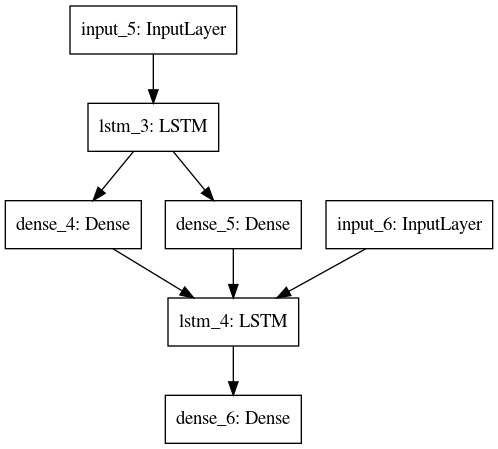

In [14]:
## AUTOENCODER MODEL DEFINITION
    
encoder_inputs = Input(shape = (None, num_encoder_tokens))
encoder_lstm = LSTM(LATENT_DIMENSIONS, return_state = True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
state_h_dense = Dense(LATENT_DIMENSIONS, activation = "sigmoid")
state_c_dense = Dense(LATENT_DIMENSIONS, activation = "sigmoid")
state_h = state_h_dense(state_h)
state_c = state_c_dense(state_c)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape = (None, num_decoder_tokens))
decoder_lstm = LSTM(LATENT_DIMENSIONS, return_sequences = True, return_state = True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state = encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation = 'softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()
plot_model(model)

In [5]:
## TRAINING (Done once per configuration)

model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = 0.2)
model.save_weights('./model_weights/quantized/s2s_' + str(EPOCHS) + "_" + str(BATCH_SIZE) + "_" + str(NUM_SAMPLES) + "_" + str(LATENT_DIMENSIONS) + ".h5")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 17s 419us/step - loss: 2.0916 - accuracy: 0.4308 - val_loss: 2.4402 - val_accuracy: 0.3160
Epoch 2/50
40000/40000 [==============================] - 15s 373us/step - loss: 1.6128 - accuracy: 0.5381 - val_loss: 2.0246 - val_accuracy: 0.4102
Epoch 3/50
40000/40000 [==============================] - 15s 377us/step - loss: 1.4370 - accuracy: 0.5763 - val_loss: 1.8840 - val_accuracy: 0.4405
Epoch 4/50
40000/40000 [==============================] - 15s 376us/step - loss: 1.3443 - accuracy: 0.5992 - val_loss: 1.8047 - val_accuracy: 0.4581
Epoch 5/50
40000/40000 [==============================] - 15s 378us/step - loss: 1.2754 - accuracy: 0.6150 - val_loss: 1.7287 - val_accuracy: 0.4739
Epoch 6/50
40000/40000 [==============================] - 15s 376us/step - loss: 1.2172 - accuracy: 0.6302 - v

In [15]:
## LOADING PRETRAINED WEIGHTS

model.load_weights('./model_weights/quantized/s2s_' + str(EPOCHS) + "_" + str(BATCH_SIZE) + "_" + str(NUM_SAMPLES) + "_" + str(LATENT_DIMENSIONS) + ".h5")

In [16]:
## INFERENCE MODEL

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape = (LATENT_DIMENSIONS,))
decoder_state_input_c = Input(shape = (LATENT_DIMENSIONS,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [17]:
def quantize(x):
    return (x > 0.5).astype(float)

In [18]:
def decode_sequence(input_seq, quant = False):
    states_value = encoder_model.predict(input_seq)
    if quant:
        states_value[0] = quantize(states_value[0])
        states_value[1] = quantize(states_value[1])
    
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence

In [21]:
## VALIDATION TESTING

start = int(NUM_SAMPLES * 0.9) + 100
samples = 100

bleu_val = 0
cosine_val = 0
jaccard_val = 0
levenshtein_val = 0

cosine = Cosine(1)
jaccard = Jaccard(1)
levenshtein = Levenshtein()
smoothie = SmoothingFunction().method4

for seq_index in range(start, start + samples):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    decoded_sentence_quant = decode_sequence(input_seq, quant = True)
    
    cosine_val += cosine.distance(input_texts[seq_index], decoded_sentence_quant)
    jaccard_val += jaccard.distance(input_texts[seq_index], decoded_sentence_quant)
    levenshtein_val += levenshtein.distance(input_texts[seq_index], decoded_sentence_quant)
    bleu_val += bleu([input_texts[seq_index].split()], decoded_sentence_quant.split(), smoothing_function = smoothie)    
    
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)
    print('Quantized Decoded sentence:', decoded_sentence_quant)
    
print("BLEU Score = ", round(1. - (bleu_val / samples), 4))
print("Cosine Score = ", round(cosine_val / samples, 4))
print("Jaccard Score = ", round(jaccard_val / samples, 4))
print("Levenshtein Score = ", round(levenshtein_val / samples, 4))

-
Input sentence: when will you be back
Decoded sentence: whe mes you be for me

Quantized Decoded sentence: whes we be benybery done

-
Input sentence: when will you be free
Decoded sentence: whe mes you be for me

Quantized Decoded sentence: whes we be benybery done

-
Input sentence: when will you be free
Decoded sentence: whe mes you be for me

Quantized Decoded sentence: whes we be benybery done

-
Input sentence: where are my children
Decoded sentence: where your sie a love

Quantized Decoded sentence: wes weres be bery tere fo
-
Input sentence: where are my scissors
Decoded sentence: where are all tom mes

Quantized Decoded sentence: wes meres bery fely homes
-
Input sentence: where are my slippers
Decoded sentence: where are are ar furt

Quantized Decoded sentence: wes mere were relly well 
-
Input sentence: where are my slippers
Decoded sentence: where are are ar furt

Quantized Decoded sentence: wes mere were relly well 
-
Input sentence: where are my slippers
Decoded sentenc

-
Input sentence: where were the police
Decoded sentence: wel we come some hear

Quantized Decoded sentence: wed keeked the learn you

-
Input sentence: where were they going
Decoded sentence: we kees wean caly her

Quantized Decoded sentence: wed keekes there angand

-
Input sentence: where were they going
Decoded sentence: we kees wean caly her

Quantized Decoded sentence: wed keekes there angand

-
Input sentence: where were you hiding
Decoded sentence: we kees and createre

Quantized Decoded sentence: wed keessed me read men

-
Input sentence: where were you hiding
Decoded sentence: we kees and createre

Quantized Decoded sentence: wed keessed me read men

-
Input sentence: wherere toms things
Decoded sentence: wel were hand hime

Quantized Decoded sentence: wed kekswes whing this

-
Input sentence: wheres everyone else
Decoded sentence: where free for fored

Quantized Decoded sentence: wes keepked your reme me

-
Input sentence: wheres everyone else
Decoded sentence: where free fo